In [1]:
import anndata as ad
import numpy as np
import scipy
import pandas as pd
import torch
import scanpy as sc

### Larry Data Loading and Preprocessing

This normalized count matrix reports the number of transcripts (UMIs) for each gene in each cell, after total-counts normalization (i.e. L1 normalization on cells). Rows represent cells and columns represent genes. There are no column or row labels. Gene names and cell metadata are provided in separate files.

In [2]:
normed_counts = "/Users/apple/Desktop/KB/Dataset1/stateFate_inVitro_normed_counts.mtx.gz"  #snakemake.input['normed_counts']
gene_names = "/Users/apple/Desktop/KB/Dataset1/stateFate_inVitro_gene_names.txt.gz" #snakemake.input['gene_names']
clone_matrix = "/Users/apple/Desktop/KB/Dataset1/stateFate_inVitro_clone_matrix.mtx.gz" #snakemake.input['clone_matrix']
metadata = "/Users/apple/Desktop/KB/Dataset1/stateFate_inVitro_metadata.txt.gz" #snakemake.input['metadata']

# output_d4d6_h5ad = "/Users/apple/Desktop/KB/SCSeq_LineageBarcoding2/SCSeq_LineageBarcoding/Larry_test/tacco_output/d4d6_h5ad" #snakemake.output['d4d6_h5ad']
# output_d2_h5ad = "/Users/apple/Desktop/KB/SCSeq_LineageBarcoding2/SCSeq_LineageBarcoding/Larry_test/tacco_output/d2_h5ad" #snakemake.output['d2_h5ad']

In [3]:
# load data
normed_counts_mat = scipy.io.mmread(normed_counts).tocsr()
genes = pd.read_csv(gene_names, sep='\t',header=None).to_numpy().flatten()
clone_mat = scipy.io.mmread(clone_matrix).tocsr()
meta_df = pd.read_csv(metadata, sep='\t')

# create full adata
adata = ad.AnnData(normed_counts_mat, obs=meta_df, var=pd.DataFrame(index=genes), dtype=np.float32)

# optimize dtypes
adata.obs['Library'] = adata.obs['Library'].astype('category')
adata.obs['Time point'] = adata.obs['Time point'].astype(int)
adata.obs['Starting population'] = adata.obs['Starting population'].astype('category')
adata.obs['Cell type annotation'] = adata.obs['Cell type annotation'].astype('category')
adata.obs['Well'] = adata.obs['Well'].astype(int)
# assign clone_id
adata.obs['clone_id'] = (clone_mat @ np.arange(1,1+clone_mat.shape[1])) - 1

/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [4]:
adata.obs

,Library,Cell barcode,Time point,Starting population,Cell type annotation,Well,SPRING-x,SPRING-y,clone_id
0,d6_2_2,GCGTGCAA-AGAAGTTA,6,Lin-Kit+Sca1-,Undifferentiated,2,411.496,-96.190,573
1,d6_2_2,AAGGGACC-CTCGATGC,6,Lin-Kit+Sca1-,Undifferentiated,2,-587.462,-306.925,1440
2,d6_2_2,CGTACCGA-AGCGCCTT,6,Lin-Kit+Sca1-,Monocyte,2,1429.805,-429.300,394
3,d6_2_2,CTGAAGGG-AGGAGCTT,6,Lin-Kit+Sca1-,Neutrophil,2,1150.028,-2030.369,-1
4,d6_2_2,CCGTAGCT-AGGCAGTT,6,Lin-Kit+Sca1-,Undifferentiated,2,-1169.594,362.010,1972
...,...,...,...,...,...,...,...,...,...
130882,LSK_d6_1_3,TCTGATTT-CGGGCTTT,6,Lin-Kit+Sca1+,Undifferentiated,1,-308.468,-163.223,-1
130883,LSK_d6_1_3,AGTCACAA-TGTGTCCT,6,Lin-Kit+Sca1+,Undifferentiated,1,-3.435,575.133,1374
130884,LSK_d6_1_3,GGAGGTTT-AGGCAGTT,6,Lin-Kit+Sca1+,Monocyte,1,2548.309,24.683,-1
130885,LSK_d6_1_3,CCGGAAAT-GGGAAGGT,6,Lin-Kit+Sca1+,Monocyte,1,2658.601,131.098,-1


In [5]:
print("number of lineages: ", len(adata.obs['clone_id'].unique()))

number of lineages:  5865


In [6]:
(adata.obs['clone_id'].value_counts()).value_counts()

count
2        1598
3         891
4         558
5         420
6         315
         ... 
83          1
85          1
86          1
87          1
81585       1
Name: count, Length: 99, dtype: int64

## UMAP for all 130887 cells

In [7]:
# selcect top 2000 highly variable genes

sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata,n_top_genes=2000)
# sc.pl.highly_variable_genes(adata)

/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:215: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']


In [8]:
adata = adata[:, adata.var.highly_variable]

In [9]:
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)

/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:842: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


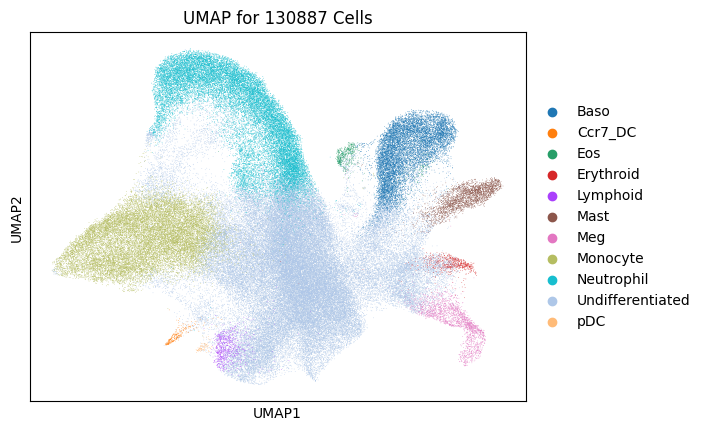

In [10]:
sc.pl.umap(adata,color='Cell type annotation', title= "UMAP for 130887 Cells")

## UMAP for 41201 cells

In [11]:
130887-81585-1598*2-891*3-558*4

41201

In [12]:
# create full adata
adata_cp = ad.AnnData(normed_counts_mat, obs=meta_df, var=pd.DataFrame(index=genes), dtype=np.float32)

# optimize dtypes
adata_cp.obs['Library'] = adata_cp.obs['Library'].astype('category')
adata_cp.obs['Time point'] = adata_cp.obs['Time point'].astype(int)
adata_cp.obs['Starting population'] = adata_cp.obs['Starting population'].astype('category')
adata_cp.obs['Cell type annotation'] = adata_cp.obs['Cell type annotation'].astype('category')
adata_cp.obs['Well'] = adata_cp.obs['Well'].astype(int)
# assign clone_id
adata_cp.obs['clone_id'] = (clone_mat @ np.arange(1,1+clone_mat.shape[1])) - 1

/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [15]:
value_counts = adata.obs['clone_id'].value_counts()

frequency_dict = {}
for value, count in value_counts.items():
    if count in frequency_dict:
        frequency_dict[count].append(value)
    else:
        frequency_dict[count] = [value]

#  print(frequency_dict)

clone_for_remove = frequency_dict[81585]+frequency_dict[2]+frequency_dict[3]+frequency_dict[4] 
adata_subset = adata_cp[~adata_cp.obs['clone_id'].isin(clone_for_remove)]

adata_subset.obs.shape
adata_subset.X.shape

(41201, 25289)

In [31]:
adata.var.highly_variable

0610043K17Rik    True
1600012P17Rik    True
1700001C19Rik    True
1700001J03Rik    True
1700001O22Rik    True
                 ... 
Zfpm2            True
Zmiz1os1         True
Zmpste24         True
Zmynd15          True
Zpld1            True
Name: highly_variable, Length: 2000, dtype: bool

In [25]:
hvgene = (adata.var.highly_variable).index

In [26]:
# selcect top 2000 highly variable genes

sc.pp.log1p(adata_subset)
adata_subset = adata_subset[:,hvgene]
adata_subset.X.shape

(41201, 2000)

In [27]:
sc.pp.scale(adata_subset, max_value=10)
sc.tl.pca(adata_subset, svd_solver='arpack')
sc.pp.neighbors(adata_subset, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata_subset)


/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:842: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


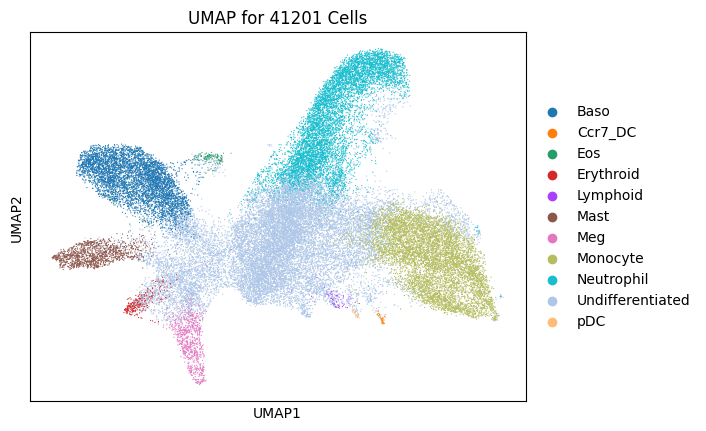

In [28]:
sc.pl.umap(adata_subset,color='Cell type annotation', title="UMAP for 41201 Cells")